In [6]:
import torch
import torch.nn as nn

id_op = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']

node_ops = [[]]*10
node_ops[0] = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[1] = ['none']
node_ops[2] = ['nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[3] = ['nor_conv_1x1','nor_conv_3x3']
node_ops[4] = ['skip_connect','avg_pool_3x3']
node_ops[5] = ['nor_conv_1x1']
node_ops[6] = ['nor_conv_3x3']
node_ops[7] = ['skip_connect']
node_ops[8] = ['avg_pool_3x3']

L = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

'''
References: NATS-Bench source code (on topology search space (tss)): 
https://github.com/D-X-Y/AutoDL-Projects/tree/f46486e21b71ae6459a700be720d7648b5429569/xautodl

The following classes are modified compared to original version: MixedOp, Cell

Arch (seems to) play the role of Gentotypes in the original implementation
Cell (seems to) play the role of InferCell in the original implementation
'''

OPS = {
    "none": lambda C_in, C_out, stride, affine, track_running_stats: Zero(
        C_in, C_out, stride
    ),
    "avg_pool_3x3": lambda C_in, C_out, stride, affine, track_running_stats: POOLING(
        C_in, C_out, stride, "avg", affine, track_running_stats
    ),
    "nor_conv_3x3": lambda C_in, C_out, stride, affine, track_running_stats: ReLUConvBN(
        C_in,
        C_out,
        (3, 3),
        (stride, stride),
        (1, 1),
        (1, 1),
        affine,
        track_running_stats,
    ),
    "nor_conv_1x1": lambda C_in, C_out, stride, affine, track_running_stats: ReLUConvBN(
        C_in,
        C_out,
        (1, 1),
        (stride, stride),
        (0, 0),
        (1, 1),
        affine,
        track_running_stats,
    ),
    "skip_connect": lambda C_in, C_out, stride, affine, track_running_stats: Identity()
    if stride == 1 and C_in == C_out
    else FactorizedReduce(C_in, C_out, stride, affine, track_running_stats),
}

class ReLUConvBN(nn.Module):
    def __init__(
        self,
        C_in,
        C_out,
        kernel_size,
        stride,
        padding,
        dilation,
        affine,
        track_running_stats=True,
    ):
        super(ReLUConvBN, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(
                C_in,
                C_out,
                kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                bias=not affine,
            ),
            nn.BatchNorm2d(
                C_out, affine=affine, track_running_stats=track_running_stats
            ),
        )

    def forward(self, x):
        return self.op(x)

class POOLING(nn.Module):
    def __init__(
        self, C_in, C_out, stride, mode, affine=True, track_running_stats=True
    ):
        super(POOLING, self).__init__()
        if C_in == C_out:
            self.preprocess = None
        else:
            self.preprocess = ReLUConvBN(
                C_in, C_out, 1, 1, 0, 1, affine, track_running_stats
            )
        if mode == "avg":
            self.op = nn.AvgPool2d(3, stride=stride, padding=1, count_include_pad=False)
        elif mode == "max":
            self.op = nn.MaxPool2d(3, stride=stride, padding=1)
        else:
            raise ValueError("Invalid mode={:} in POOLING".format(mode))

    def forward(self, inputs):
        if self.preprocess:
            x = self.preprocess(inputs)
        else:
            x = inputs
        return self.op(x)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class Zero(nn.Module):
    def __init__(self, C_in, C_out, stride):
        super(Zero, self).__init__()
        self.C_in = C_in
        self.C_out = C_out
        self.stride = stride
        self.is_zero = True

    def forward(self, x):
        if self.C_in == self.C_out:
            if self.stride == 1:
                return x.mul(0.0)
            else:
                return x[:, :, :: self.stride, :: self.stride].mul(0.0)
        else:
            shape = list(x.shape)
            shape[1] = self.C_out
            zeros = x.new_zeros(shape, dtype=x.dtype, device=x.device)
            return zeros

    def extra_repr(self):
        return "C_in={C_in}, C_out={C_out}, stride={stride}".format(**self.__dict__)

class FactorizedReduce(nn.Module):
    def __init__(self, C_in, C_out, stride, affine, track_running_stats):
        super(FactorizedReduce, self).__init__()
        self.stride = stride
        self.C_in = C_in
        self.C_out = C_out
        self.relu = nn.ReLU(inplace=False)
        if stride == 2:
            # assert C_out % 2 == 0, 'C_out : {:}'.format(C_out)
            C_outs = [C_out // 2, C_out - C_out // 2]
            self.convs = nn.ModuleList()
            for i in range(2):
                self.convs.append(
                    nn.Conv2d(
                        C_in, C_outs[i], 1, stride=stride, padding=0, bias=not affine
                    )
                )
            self.pad = nn.ConstantPad2d((0, 1, 0, 1), 0)
        elif stride == 1:
            self.conv = nn.Conv2d(
                C_in, C_out, 1, stride=stride, padding=0, bias=not affine
            )
        else:
            raise ValueError("Invalid stride : {:}".format(stride))
        self.bn = nn.BatchNorm2d(
            C_out, affine=affine, track_running_stats=track_running_stats
        )

    def forward(self, x):
        if self.stride == 2:
            x = self.relu(x)
            y = self.pad(x)
            out = torch.cat([self.convs[0](x), self.convs[1](y[:, :, 1:, 1:])], dim=1)
        else:
            out = self.conv(x)
        out = self.bn(out)
        return out

    def extra_repr(self):
        return "C_in={C_in}, C_out={C_out}, stride={stride}".format(**self.__dict__)

class MixedOp(nn.Module):
    def __init__(self, ops, C_in, C_out, stride=1, affine= True, track_running_stats= True):
        super(MixedOp, self).__init__()
        self.C_in = C_in
        self.C_out = C_out
        self.affine = affine
        self.track_running_stats = track_running_stats
        self.stride = stride
        self.ops = nn.ModuleList()
        for op in ops:
            cuda_op = OPS[op](C_in, C_out, stride, affine, track_running_stats)
            self.ops.append(cuda_op)

    def forward(self, x):
        rx = torch.zeros_like(x)
        for st_op in self.ops:
            rx = rx + st_op(x)
        return rx

class Cell(nn.Module):
    def __init__(self, Arch, C_in, C_out, stride, affine= True, track_running_stats= True):
        super(Cell, self).__init__()
        self.Arch = Arch
        self.C_in = C_in
        self.C_out = C_out
        self.affine = affine
        self.track_running_stats = track_running_stats
        self.stride = stride
        self.out_dim = C_out
        self.ops = nn.ModuleList()
        for i in range(6):
            ops = node_ops[self.Arch[i]]
            st_op = MixedOp(ops, C_in, C_out)
            self.ops.append(st_op)

    def forward(self, x):
        layers = [torch.zeros_like(x)]*6
        layers[0] = x
        for i in range(6):
            s, t = L[i]
            st_op = self.ops[i]
            layers[t] = layers[t] + st_op(layers[s])
        return layers[3]

class ResNetBasicblock(nn.Module):
    def __init__(self, inplanes, planes, stride, affine=True, track_running_stats=True):
        super(ResNetBasicblock, self).__init__()
        assert stride == 1 or stride == 2, "invalid stride {:}".format(stride)
        self.conv_a = ReLUConvBN(
            inplanes, planes, 3, stride, 1, 1, affine, track_running_stats
        )
        self.conv_b = ReLUConvBN(
            planes, planes, 3, 1, 1, 1, affine, track_running_stats
        )
        if stride == 2:
            self.downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
                nn.Conv2d(
                    inplanes, planes, kernel_size=1, stride=1, padding=0, bias=False
                ),
            )
        elif inplanes != planes:
            self.downsample = ReLUConvBN(
                inplanes, planes, 1, 1, 0, 1, affine, track_running_stats
            )
        else:
            self.downsample = None
        self.in_dim = inplanes
        self.out_dim = planes
        self.stride = stride
        self.num_conv = 2

    def extra_repr(self):
        string = "{name}(inC={in_dim}, outC={out_dim}, stride={stride})".format(
            name=self.__class__.__name__, **self.__dict__
        )
        return string

    def forward(self, inputs):

        basicblock = self.conv_a(inputs)
        basicblock = self.conv_b(basicblock)

        if self.downsample is not None:
            residual = self.downsample(inputs)
        else:
            residual = inputs
        return residual + basicblock

class TinyNetwork(nn.Module):
    def __init__(self, C, N, Arch, num_classes):
        '''
        Initial Macro parameters (according to NAS-Bench-201):
        C: Input channel of 1st stack: 16
        N: Number of DAG-Cell/stack: 5
        num_classes: =10 on CIFAR-10 (probably?)
        '''
        super(TinyNetwork, self).__init__()
        self._C = C
        self._layerN = N
        self.Arch = Arch
        self.num_classes = num_classes

        self.stem = nn.Sequential(
            nn.Conv2d(3, C, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(C)
        )

        layer_channels = [C] * N + [C * 2] + [C * 2] * N + [C * 4] + [C * 4] * N
        layer_reductions = [False] * N + [True] + [False] * N + [True] + [False] * N

        C_prev = C
        self.cells = nn.ModuleList()
        for index, (C_curr, reduction) in enumerate(
            zip(layer_channels, layer_reductions)
        ):
            if reduction:
                cell = ResNetBasicblock(C_prev, C_curr, 2, True)
            else:
                cell = Cell(Arch, C_prev, C_curr, 1)
            self.cells.append(cell)
            C_prev = cell.out_dim
        self._Layer = len(self.cells)

        self.lastact = nn.Sequential(nn.BatchNorm2d(C_prev), nn.ReLU(inplace=True))
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(C_prev, num_classes)

    def get_message(self):
        string = self.extra_repr()
        for i, cell in enumerate(self.cells):
            string += "\n {:02d}/{:02d} :: {:}".format(
                i, len(self.cells), cell.extra_repr()
            )
        return string

    def extra_repr(self):
        return "{name}(C={_C}, N={_layerN}, L={_Layer})".format(
            name=self.__class__.__name__, **self.__dict__
        )

    def forward(self, inputs):
        feature = self.stem(inputs)
        for i, cell in enumerate(self.cells):
            feature = cell(feature)

        out = self.lastact(feature)
        out = self.global_pooling(out)
        out = out.view(out.size(0), -1)
        logits = self.classifier(out)

        return out

In [9]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

num_epochs = 2
batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
train_indices = range(25000)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=train_indices)
#tao sẽ thêm phần validation sau

val_indices = range(25000,50000)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=val_indices)

final_indices = range(50000)
finalloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False,sampler=final_indices)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_metric(Arch, final= False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = TinyNetwork(16,5,Arch,10)
    net.to(device)
    criterion  = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9,nesterov=True,weight_decay=0.0005)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 200,eta_min=0)

    global num_epochs
    
    if final:
        num_epochs = 25
        train_acc = []
    else:
        num_epochs = 2
    
    for epoch in range(num_epochs):
        net.train()
#         scheduler.step()
        loader = trainloader
        train_total = 0
        train_correct = 0
        if final:
            loader = finalloader
        for inputs, labels in loader:
            inputs,labels = inputs.to(device),labels.to(device)
            # get the inputs; data is a list of [inputs, labels]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.cpu().detach().size(0)
            train_correct += (predicted == labels).sum().item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        if final:
            train_acc.append(train_correct/train_total)
    if final:
        plt.plot(train_acc)
        plt.show()
    with torch.no_grad():
        correct = 0
        total = 0
        net.eval()
        loader = valloader
        if final:
            loader = testloader
        for inputs, labels in loader: #về sau ở đây t sẽ thay bằng validation
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = net(inputs.float())
            loss = criterion(outputs,labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.cpu().detach().size(0)
            correct += (predicted == labels).sum().item()

        acc = float(correct/total)
        if final:
            print('Final Judge:')
        print(f'Accuracy of the network on the 10000 test images: {100 * acc} %')
    return acc

Files already downloaded and verified
Files already downloaded and verified


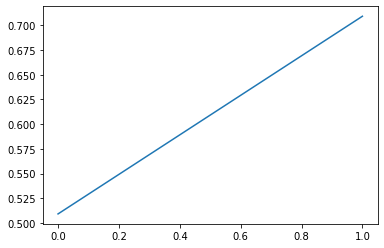

Final Judge:
Accuracy of the network on the 10000 test images: 66.96 %


In [11]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
# from nas_201_api import NASBench201API as API

# Operation tree design
node_ops = [[]]*9 # operations on id-th node
e = [[]]*9 # edge list
par = [-1]*9 # parent list

e[0] = [1,2]
e[2] = [3,4]
e[3] = [5,6]
e[4] = [7,8]

par[1] = 0
par[2] = 0
par[3] = 2
par[4] = 2
par[5] = 3
par[6] = 3
par[7] = 4
par[8] = 4


node_ops[0] = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[1] = ['none']
node_ops[2] = ['nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
node_ops[3] = ['nor_conv_1x1','nor_conv_3x3']
node_ops[4] = ['skip_connect','avg_pool_3x3']
node_ops[5] = ['nor_conv_1x1']
node_ops[6] = ['nor_conv_3x3']
node_ops[7] = ['skip_connect']
node_ops[8] = ['avg_pool_3x3']

# Cell's DAG edge list
L = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

# Encoding candidates and operations
id_op = ['none','nor_conv_1x1','nor_conv_3x3','skip_connect','avg_pool_3x3']
masks = []

def To_mask(num):
    res = ''
    while(num > 0):
        res += str(num % 2)
        num = int(num/2)
    while(len(res) < 6):
        res += '0'
    res = res[::-1]
    return res

def Build_masks():
    mask_len = 2**6 - 1
    for i in range(mask_len + 1):
        masks.append(To_mask(i))
    print("Build_masks: Done")

def Build_cand_arch(Arch, mask):
    Cand_arch = []
    Len = len(mask)
    for i in range(Len):
        if len(e[Arch[i]]) < 2:
            Cand_arch.append(Arch[i])
            continue
        o0 = e[Arch[i]][0]
        o1 = e[Arch[i]][1]
        b = mask[i]
        op = o0
        if b == '1':
            op = o1
        Cand_arch.append(op)
    return Cand_arch

def Score(Arch, final= False):
    return get_metric(Arch, final)

def Check_connected(Arch):
    '''
    if (Arch[0] == 1) and (Arch[1] == 1) and (Arch[2] == 1):
        return False
    if (Arch[4] == 1) and (Arch[5] == 1):
        return False
    '''
    fr = [True]*4
    fr[0] = False
    for i in range(6):
        s, t = L[i]
        if Arch[i] == 1:
            continue
        fr[t] = (fr[t] and fr[s])
    return not fr[3]

def BFS_T_o():
    Arch = [0,0,0,0,0,0]
    q = []
    q.insert(0,0) # queue.push()
    for i in range(3):
        Cur_arch = Build_cand_arch(Arch, To_mask(0))
        print(i, Cur_arch)
        score = Score(Cur_arch)
        for mask in masks:
            Cand_arch = Build_cand_arch(Arch, mask)
            print(mask, Cand_arch, Check_connected(Cand_arch))
            if not Check_connected(Cand_arch):
                continue
            if Cur_arch == Cand_arch: 
                continue
            cand_score = Score(Cand_arch)
            if score < cand_score:
                Cur_arch = Cand_arch
                score = cand_score
        Arch = Cur_arch
    print(Arch)
    final_score = Score(Arch, final= True)

Build_masks()
BFS_T_o()